# just show result from one of q1,q2,q3

```html
<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>
```

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# What is this?
 (originally created 11/03/2015)
- here, I go further and **analyze** the result a bit more
- I'll dig in the stability of model selection by studying the gridsearch result

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cPickle as pickle
import pandas as pd
import os
import sys

import sklearn.metrics as skmetrics
import warnings
from IPython.display import display

import tak.tak as tw
import tak.data_io as twio
reload(tw)
reload(twio)

from pandas import DataFrame as DF
from pandas import Series as SR

pd.set_option('precision', 4)

In [4]:
# pklname = "pnc_ncv10fold_acc_sklLogregL1_age_q1_rsouter336970_rsinner337862.pkl"
pklname = 'pnc_ncv10fold_acc_sklLogregL1_age_q2_rsouter168519_rsinner50426.pkl'
# pklname = 'pnc_ncv10fold_acc_sklLogregL1_age_q3_rsouter271477_rsinner175307.pkl'

data_fullpath = "/home/takanori/work-local/tak-ace-ibis/python/analysis/pnc/"+\
                "ncv_conn_random/dump/sklLogregL1/"+pklname

# Load data

In [5]:
with open(data_fullpath) as f:
    pkl_in = pickle.load(f)

# assign variables to workspace
for key,value in pkl_in.iteritems():
    globals()[key] = value

# Show classification result

In [6]:
tw.clf_summary(ytrue,ypred)

scores                                                  counts           \
         ACC    TPR    TNR    FPR    FNR     F1    PPV    NPV     TP   TN  FP   
value  0.784  0.754  0.807  0.142  0.246  0.748  0.742  0.816     98  142  34   

                          
       FN    P    N  ALL  
value  32  132  174  306

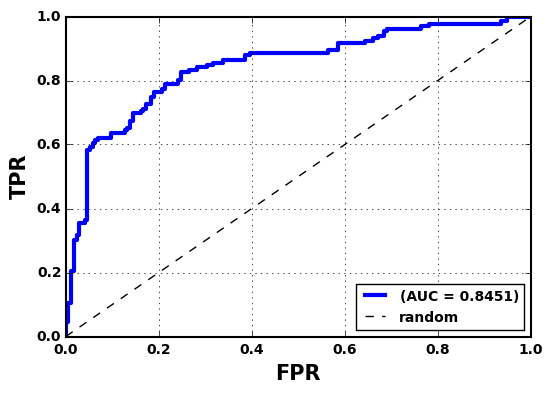

In [7]:
df_results = tw.clf_summary(ytrue,ypred)

fpr,tpr,auc = tw.roc(ytrue,score)

plt.plot(fpr,tpr,label='(AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--',label='random',lw=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('')
plt.legend(loc='best')
plt.grid('on')

# Display median coefficients

**Get node info**

In [8]:
from nilearn.plotting import plot_connectome

mni_coord = tw.get_mni_coord86()
df_node = tw.get_node_info86()

display(df_node.head(3))

,label,name_full,lobes,name_short,system,x,y,z,hemisphere,xmni,ymni,zmni
0,1001,ctx-lh-bankssts,L temporal,Bank of the Superior Temporal Sulcus,auditory,178,158,83,L,-54.15,-45.20,9.35
1,1002,ctx-lh-caudalanteriorcingulate,L frontal,Caudal Anterior Cingulate,cingulo-opercular,130,91,102,L,-4.35,17.15,29.15
2,1003,ctx-lh-caudalmiddlefrontal,L frontal,Caudal Middle Frontal,fronto-parietal,158,101,121,L,-36.45,10.20,47.45


**Construct median weight vector for each age-group**

In [9]:
coef_ = []
for clf_tuned in cv_summary['clf_tuned']:
    try:
        coef_.append(clf_tuned.coef_.ravel())
    except:
        # SPAMS toolbox: I assigned w_ for coefficient....fix this in future version?
        coef_.append(clf_tuned.w_.ravel())
        
# convert list to ndarray
coef_array = np.vstack(coef_).T
# print coef_array.shape

coef_median = np.median(coef_array,axis=1)

## Display median connmat

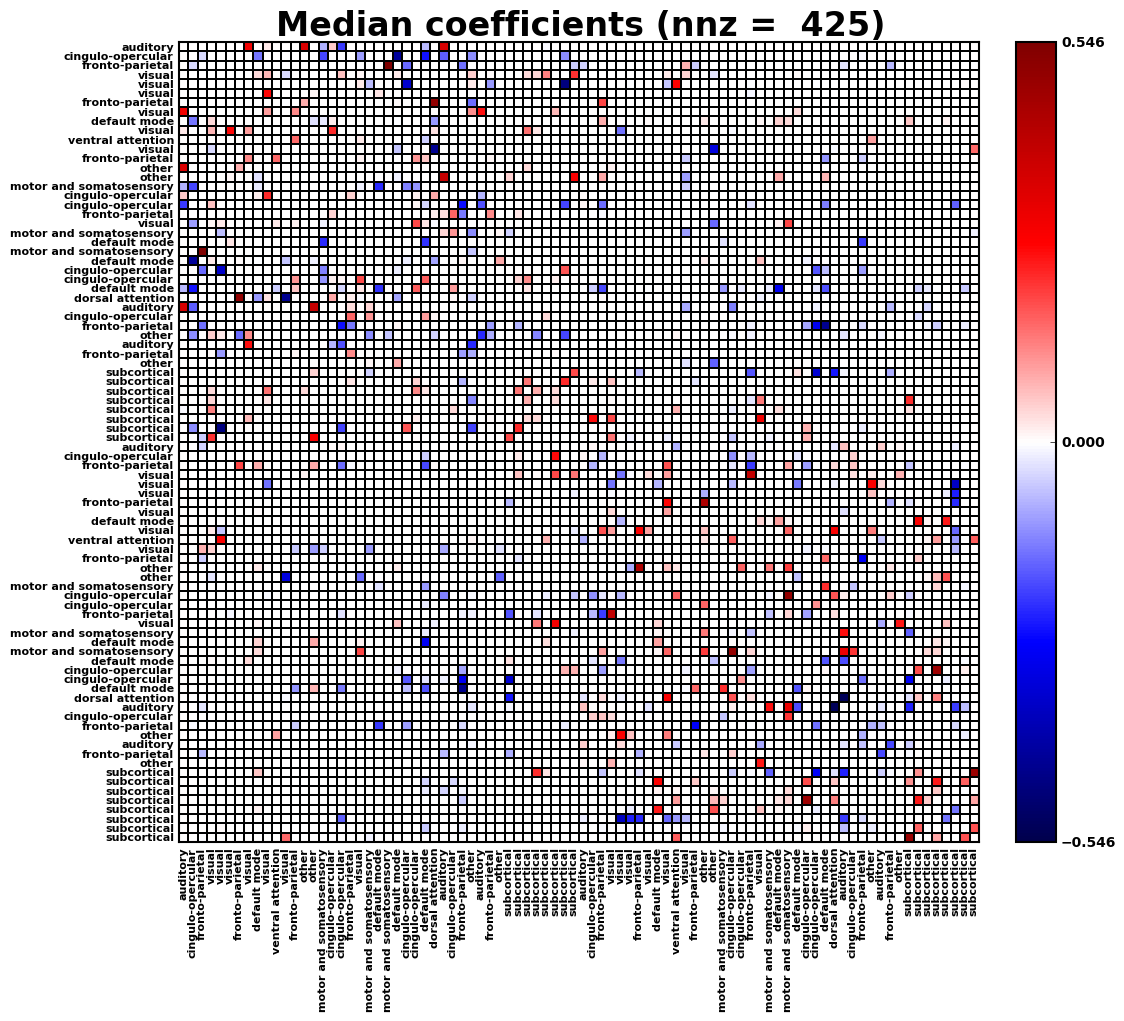

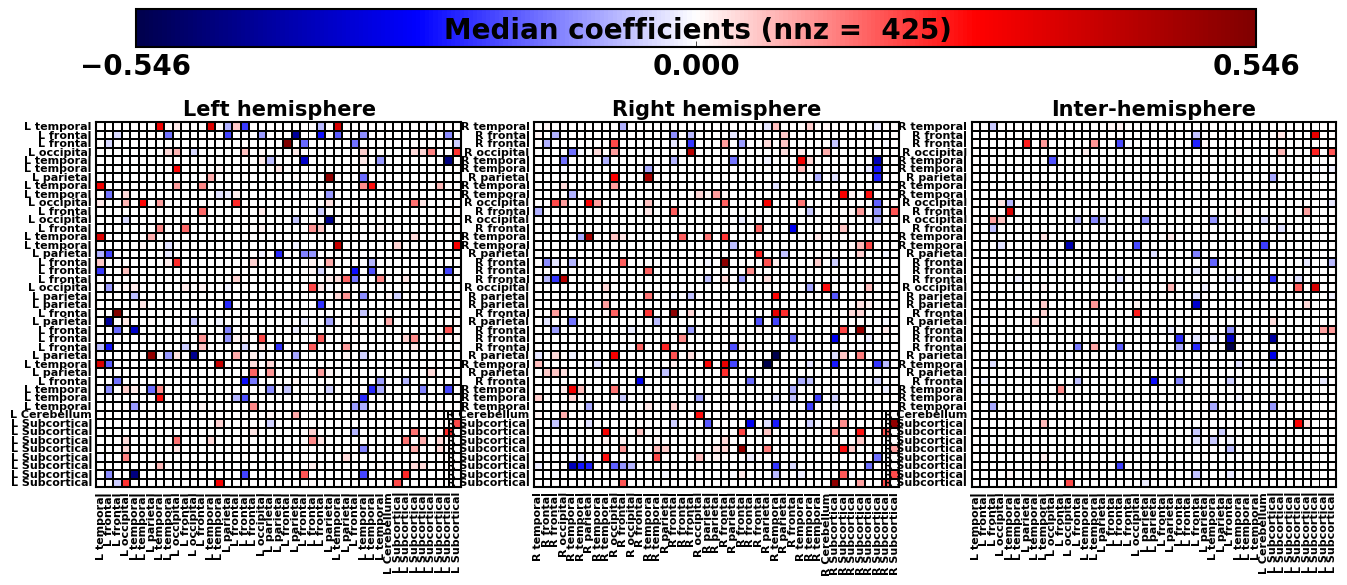

In [10]:
reload(tw)
#=== decide on x/y ticks === #
# tick = df_node.lobes.values
# tick = df_node.label.values
# tick = df_node.name_full.values
# tick = df_node.name_short.values
tick = df_node.system.values


tick = df_node.system.values

plt.figure(figsize=(12,10))
tw.imconnmat(coef_median,tick,tick)
plt.colorbar(fraction=0.046, pad=0.04, ticks=tw.cbar_ticks())
plt.title('Median coefficients (nnz = {:4})'.format(np.count_nonzero(coef_median)),
         fontsize=24)

tw.imconnmat_hemi_subplot_86(coef_median,suptitle='Median coefficients (nnz = {:4})'.format(np.count_nonzero(coef_median)))

## Glass-brain
- for further brain space analysis, I should display these in BNV in Matlab

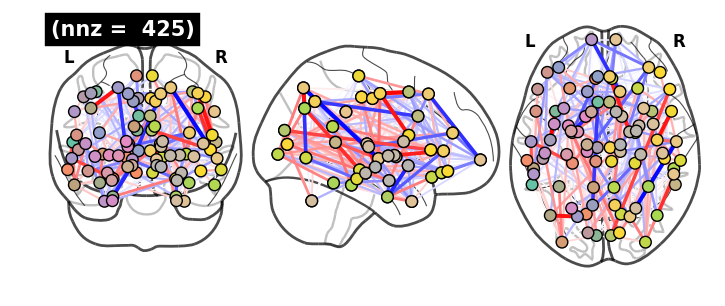

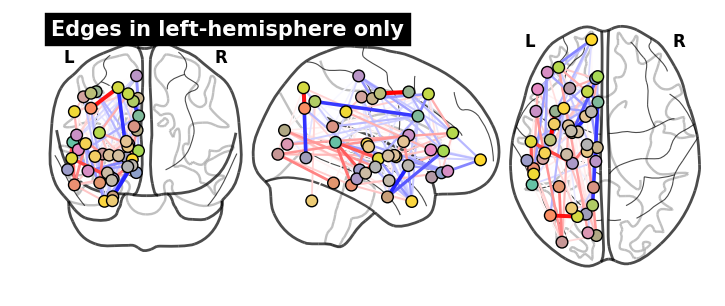

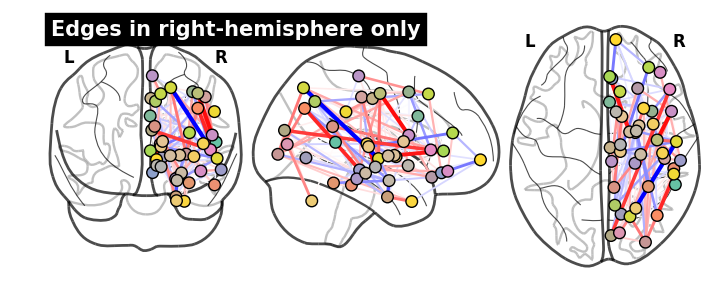

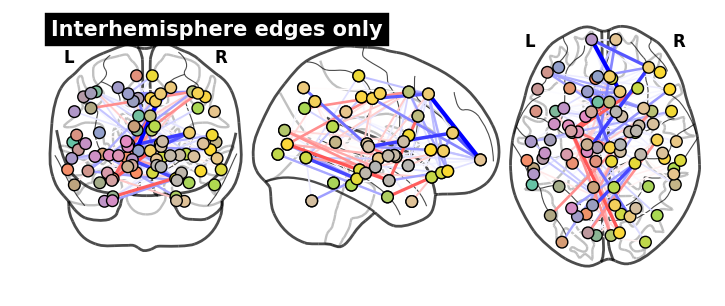

In [11]:
_ = plot_connectome(tw.sqform(coef_median), mni_coord, node_size=70, 
                    title='(nnz = {:4})'.format(np.count_nonzero(coef_median)))

# also show interhemisphere
W=tw.sqform(coef_median)

_ = plot_connectome(W[:43,:43], mni_coord[:43], node_size=70, 
                    title='Edges in left-hemisphere only')

_ = plot_connectome(W[43:,43:], mni_coord[43:], node_size=70, 
                    title='Edges in right-hemisphere only')
# 
W_inter = W
W_inter[:43,:43] = 0
W_inter[43:,43:] = 0
_ = plot_connectome(W_inter, mni_coord, node_size=70, 
                    title='Interhemisphere edges only')

# Thresholded median value (experimental)

## Trinarized median connmat after thresholding

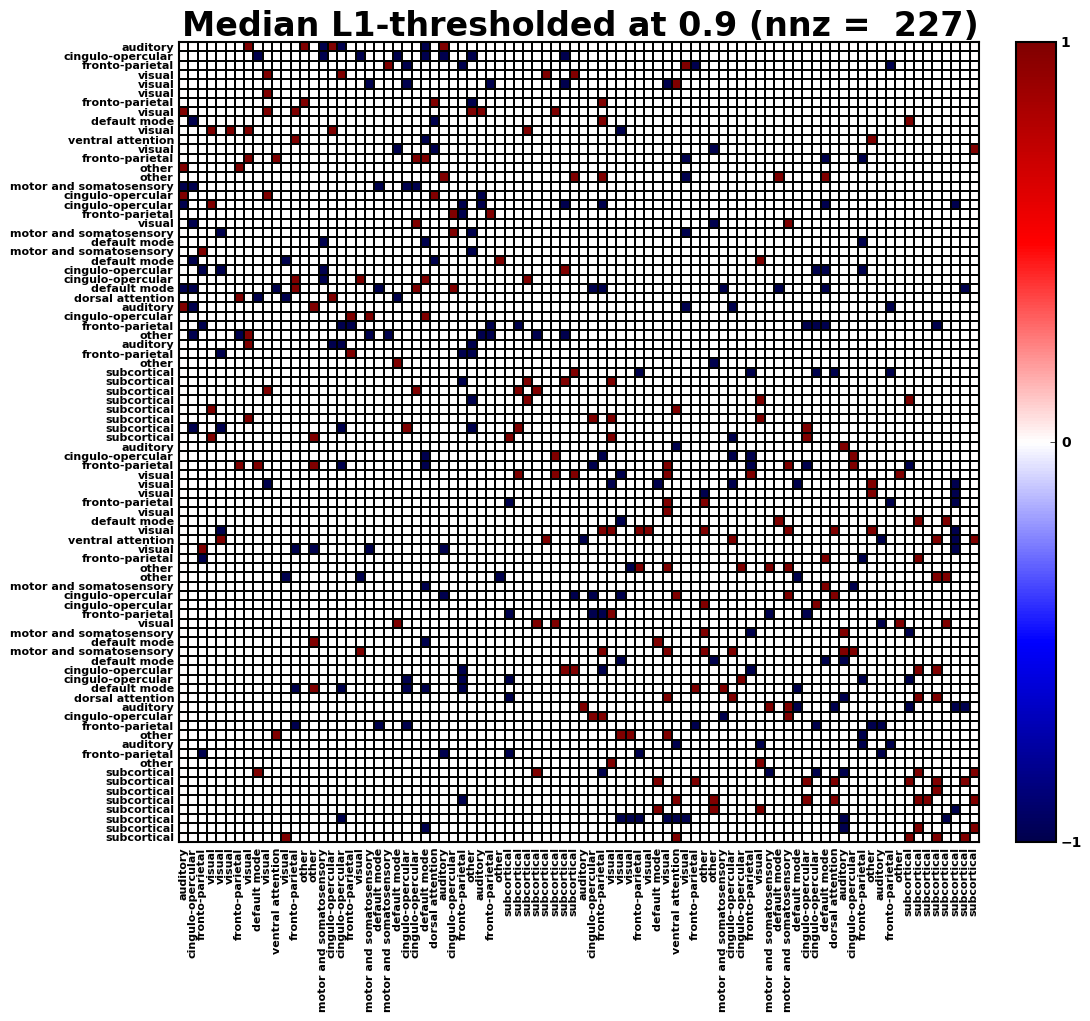

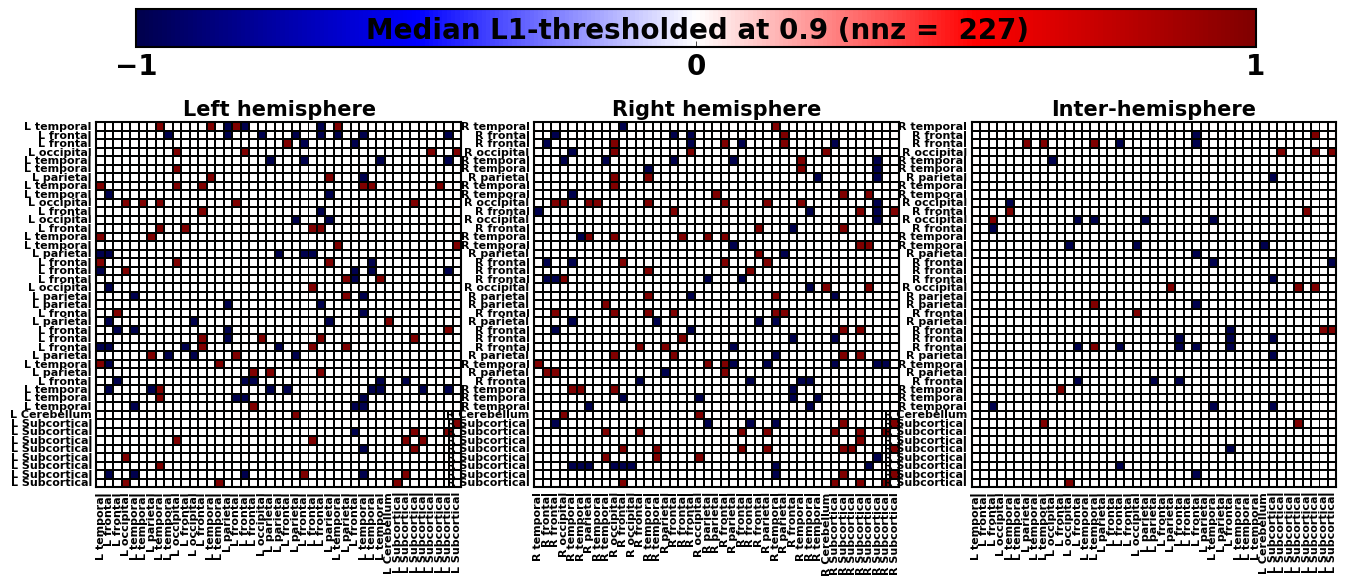

In [12]:
thresh = 0.9
coef_thresh = tw.threshold_L1conc(coef_median, thresh)

# triinarize?
coef_thresh[coef_thresh>0] = +1
coef_thresh[coef_thresh<0] = -1

plt.figure(figsize=(12,10))
tw.imconnmat(coef_thresh,tick,tick)
plt.colorbar(fraction=0.046, pad=0.04, ticks=tw.cbar_ticks())

titlestr = ('Median L1-thresholded at {:2} (nnz = {:4})'.
              format(thresh,np.count_nonzero(coef_thresh)))

plt.title(titlestr,fontsize=24)

tw.imconnmat_hemi_subplot_86(coef_thresh,suptitle=titlestr)

## Glassbrain

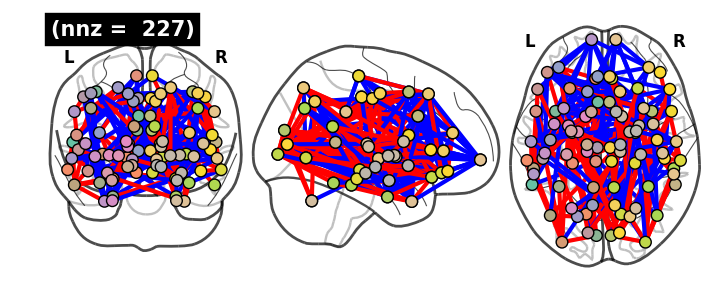

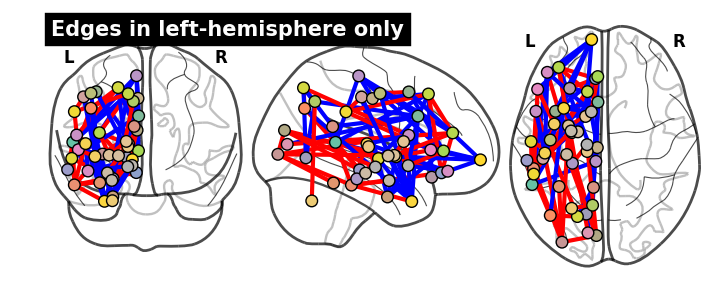

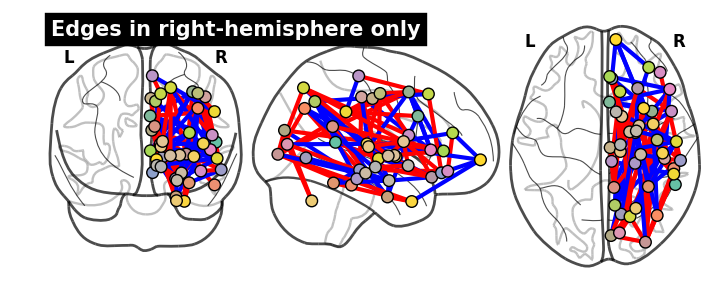

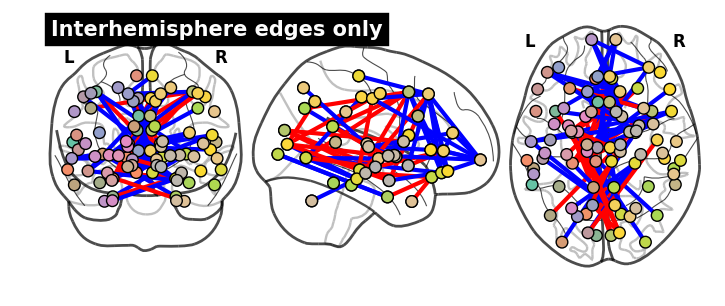

In [13]:
_ = plot_connectome(tw.sqform(coef_thresh), mni_coord, node_size=70, 
                    title='(nnz = {:4})'.format(np.count_nonzero(coef_thresh)))

# also show interhemisphere
W=tw.sqform(coef_thresh)

_ = plot_connectome(W[:43,:43], mni_coord[:43], node_size=70, 
                    title='Edges in left-hemisphere only')

_ = plot_connectome(W[43:,43:], mni_coord[43:], node_size=70, 
                    title='Edges in right-hemisphere only')
# 
W_inter = W
W_inter[:43,:43] = 0
W_inter[43:,43:] = 0
_ = plot_connectome(W_inter, mni_coord, node_size=70, 
                    title='Interhemisphere edges only')